# Create CSV with Anxiety values and timepoints, one for each of the 17 movies 

We will also make sure to downsample them using the tr which is 1.2999999523162842

In [33]:
import pandas as pd
import numpy as np
import json
import os

# Set paths
base_path = 'ds004872/derivatives/'
output_folder = 'anxiety_per_movie_TR'
os.makedirs(output_folder, exist_ok=True)

# fMRI TR in seconds
TR = 1.2999999523162842

# Get all JSON annotation files
json_files = [f for f in os.listdir(base_path) if f.endswith('.json') and f.startswith('Annot_')]

for json_file in json_files:
    movie_name = json_file.replace('Annot_', '').replace('_stim.json', '')
    
    json_path = os.path.join(base_path, json_file)
    tsv_path = os.path.join(base_path, f'Annot_{movie_name}_stim.tsv.gz')

    # Load column names + sampling rate
    with open(json_path, 'r') as f:
        meta = json.load(f)
    columns = meta['Columns']
    sampling_rate = meta.get('SamplingFrequency', 1.0)

    # Load annotation matrix
    df = pd.read_csv(tsv_path, sep='\t', compression='gzip', header=None)
    df.columns = columns

    if 'Anxiety' not in df.columns:
        print(f"⚠️ Skipping {movie_name} — no 'Anxiety' column")
        continue

    # Step size for downsampling
    step = int(round(TR * sampling_rate))  # e.g., 1.3s * 1Hz = every 1.3 → round to 1 or 2 depending

    # Downsample: pick rows spaced by TR in seconds
    anxiety_series = df['Anxiety'].iloc[::step].reset_index(drop=True)

    # Create time axis in TR steps
    time_axis = np.arange(0, len(anxiety_series)) * TR

    # Final dataframe
    anxiety_df = pd.DataFrame({
        'Time': time_axis,
        'Anxiety': anxiety_series
    })

    # Save
    out_path = os.path.join(output_folder, f'{movie_name}_anxiety_TR.csv')
    anxiety_df.to_csv(out_path, index=False)
    print(f"Saved downsampled: {out_path}")

Saved downsampled: anxiety_per_movie_TR/YouAgain_anxiety_TR.csv
Saved downsampled: anxiety_per_movie_TR/TearsOfSteel_anxiety_TR.csv
Saved downsampled: anxiety_per_movie_TR/TheSecretNumber_anxiety_TR.csv
Saved downsampled: anxiety_per_movie_TR/BigBuckBunny_anxiety_TR.csv
Saved downsampled: anxiety_per_movie_TR/Payload_anxiety_TR.csv
Saved downsampled: anxiety_per_movie_TR/Spaceman_anxiety_TR.csv
Saved downsampled: anxiety_per_movie_TR/Chatter_anxiety_TR.csv
Saved downsampled: anxiety_per_movie_TR/LessonLearned_anxiety_TR.csv
Saved downsampled: anxiety_per_movie_TR/ToClaireFromSonny_anxiety_TR.csv
Saved downsampled: anxiety_per_movie_TR/Superhero_anxiety_TR.csv
Saved downsampled: anxiety_per_movie_TR/BetweenViewings_anxiety_TR.csv
Saved downsampled: anxiety_per_movie_TR/AfterTheRain_anxiety_TR.csv
Saved downsampled: anxiety_per_movie_TR/FirstBite_anxiety_TR.csv
Saved downsampled: anxiety_per_movie_TR/Sintel_anxiety_TR.csv


In [80]:
import pandas as pd
import numpy as np
import nibabel as nib

# === CONFIG ===
subject = 'sub-S03'
session = 'ses-2'
movie = 'LessonLearned'
TR = 1.2999999523162842

# === File Paths (based on your current structure) ===
anxiety_csv = f'anxiety_per_movie_TR/{movie}_anxiety_TR.csv'
bold_nii = f'ds004892/derivatives/preprocessing/{subject}/{session}/func/{subject}_{session}_task-{movie}_space-subject_desc-ppres_bold.nii.gz'
events_tsv = f'ds004892/{subject}/{session}/func/{subject}_{session}_task-scan_acq-{movie}_events.tsv'
output_csv = f'{subject}_{movie}_anxiety_aligned.csv'

# Step 1: Load TR-aligned anxiety 
anxiety_df = pd.read_csv(anxiety_csv)

# Step 2: Load number of fMRI volumes 
img = nib.load(bold_nii)
n_vols = img.shape[-1]
print(f"fMRI has {n_vols} volumes.")

# Step 3: Get movie onset from events.tsv 
# Normalize to lower case 
events_df = pd.read_csv(events_tsv, sep="\t", header=0)
print(events_df.columns)
events_df['trial_type'] = events_df['trial_type'].str.lower()

# Find film onset
film_row = events_df[events_df['trial_type'] == 'film']
if film_row.empty:
    raise ValueError(f"No 'film' trial_type found in: {events_tsv}")

movie_onset_sec = film_row['onset'].values[0]
movie_duration = film_row['duration'].values[0]

onset_vol = int(np.floor(movie_onset_sec / TR))
expected_trs = int(np.floor(movie_duration / TR))

anx_vals = anxiety_df['Anxiety'].values[:expected_trs]

aligned = pd.Series(np.nan, index=range(n_vols))
aligned.iloc[onset_vol:onset_vol + len(anx_vals)] = anx_vals

# === Step 6: Save aligned data ===
aligned_df = pd.DataFrame({
    'fMRI_TR': np.arange(n_vols),
    'Time_sec': np.arange(n_vols) * TR,
    'Anxiety': aligned
})
aligned_df.to_csv(output_csv, index=False)
print(f"Saved aligned file: {output_csv}")

fMRI has 669 volumes.
Index(['onset', 'duration', 'trial_type'], dtype='object')
Saved aligned file: sub-S03_LessonLearned_anxiety_aligned.csv


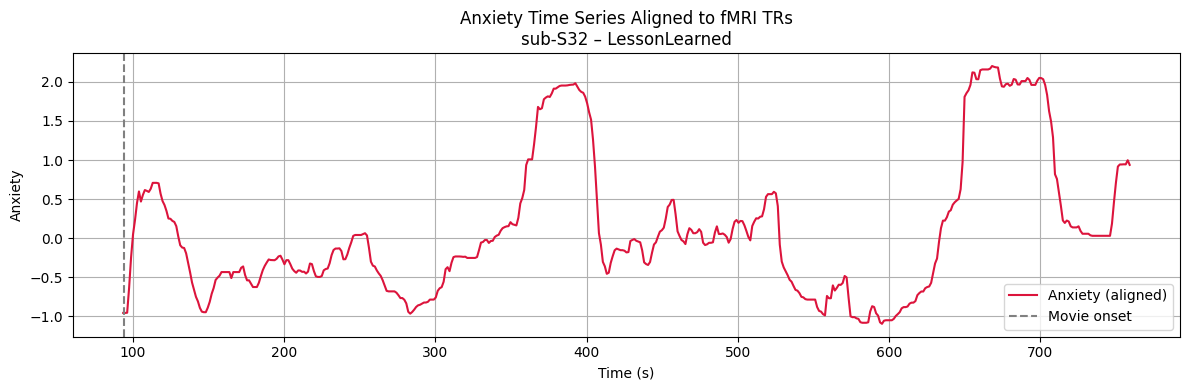

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(aligned_df['Time_sec'], aligned_df['Anxiety'], label='Anxiety (aligned)', color='crimson')
plt.axvline(x=movie_onset_sec, color='gray', linestyle='--', label='Movie onset')
plt.title(f"Anxiety Time Series Aligned to fMRI TRs\n{subject} – {movie}")
plt.xlabel("Time (s)")
plt.ylabel("Anxiety")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
import os
import pandas as pd

folder_path = "anxiety_per_movie_TR"

print(f"{'Movie':30s} {'Min':>8s} {'Max':>8s} {'Range':>8s}")
print("-" * 60)

for filename in os.listdir(folder_path):
    if filename.endswith("_anxiety_TR.csv"):
        filepath = os.path.join(folder_path, filename)
        df = pd.read_csv(filepath)

        anxiety_column = df.columns[1] # anxiety values are in the second column 
        anxiety_values = df[anxiety_column]

        min_val = anxiety_values.min()
        max_val = anxiety_values.max()
        anxiety_range = max_val - min_val

        movie_name = filename.replace("_anxiety_TR.csv", "")
        print(f"{movie_name:30s} {min_val:8.3f} {max_val:8.3f} {anxiety_range:8.3f}")

Movie                               Min      Max    Range
------------------------------------------------------------
AfterTheRain                     -1.935    2.250    4.185
Payload                          -0.926    2.270    3.196
Superhero                        -1.035    2.619    3.654
Spaceman                         -1.215    2.096    3.310
Sintel                           -0.999    2.659    3.658
LessonLearned                    -1.095    2.720    3.815
Chatter                          -0.962    3.549    4.511
BetweenViewings                  -1.277    1.105    2.382
TearsOfSteel                     -0.856    1.982    2.837
YouAgain                         -1.179    1.523    2.702
FirstBite                        -1.189    1.129    2.317
BigBuckBunny                     -1.458    2.292    3.750
ToClaireFromSonny                -1.036    1.147    2.183
TheSecretNumber                  -1.122    2.087    3.209
